All operations with the p-bits and coefficients are implemented using **PyTorch** library. 

In [36]:
import torch
import pyro
import pyro.distributions as dist

In [37]:

from collections import Counter

collect_states = Counter()

This function transforms the tensor which is a binary string to a number. It uses the fact that the first bit we don't store, because it is always equal to 1. 

In [38]:
def number_from_tensor(tensor: torch.Tensor): 
    powers_of_two = torch.vander(torch.Tensor([2]), N=tensor.size(dim=0) + 1, increasing=True)

    scalar_mul = tensor * torch.reshape(powers_of_two, (-1,))[1:]
    return scalar_mul.sum() + 1

Define the energy function we need to minimize. 

In [39]:

def energy_function(p_bits: torch.Tensor) -> torch.Tensor:
    return (number_from_tensor(p_bits[:2]) * number_from_tensor(p_bits[2:]) - 35) ** 2

In order to obtain the synaptic input values, it is crucial for us to evaluate the gradient value of energy function at the current state. It is implemented using backward propagation.   

In [40]:
def calculate_gradient(p_bits: torch.Tensor):
    energy = energy_function(p_bits)
    energy.backward(torch.ones(energy.shape))
    p_bits.retain_grad()
    return p_bits.grad

Activation function calculates the output of the p-bit using synaptic input and inverse temperature as a parameter.

In [41]:
def activation_function(syn_input: torch.Tensor, beta: float):
    return torch.heaviside(torch.tanh(beta * (-syn_input)) - (torch.rand(1) * 2 - 1), torch.tensor(0.0))

Updating the states of the circuit and save every state to Counter in order to find the most common pair.

In [47]:
def factorize(beta, visualize = True):
    
    def model():
        probabilities = torch.full((4, ), 0.5) # initial p_bits distributions
        
        p_bits = torch.tensor([pyro.sample(f"var_{i}", dist.Bernoulli(p)) for i, p in enumerate(probabilities)], requires_grad=True) # m_i states
        for i in range(100):
            indices = torch.randperm(4) # random order of bits changing
            for p_bit_index in indices:
                gradient = calculate_gradient(p_bits)
                syn_input = gradient[p_bit_index.item()] # synaptic input for the p-bit with p_bit_index
                with torch.no_grad():
                    p_bits.data[p_bit_index] = activation_function(syn_input, beta) # compute new state
                if visualize:
                    collect_states[(number_from_tensor(p_bits[:2]).item(), number_from_tensor(p_bits[2:]).item())] += 1   

    model()

Factorize the number (35) with defined optimal beta.

In [57]:
seed = 42
torch.manual_seed(seed)

optimal_inverse_temp = 2 * 10 ** (-6)

factorize(optimal_inverse_temp)


In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

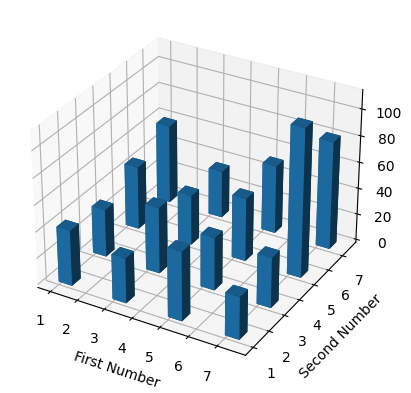

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = [key[0] for key in data.keys()]
y = [key[1] for key in data.keys()]
z = list(data.values())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, torch.zeros_like(torch.tensor(z)), dx=0.5, dy=0.5, dz=z, shade=True)
ax.set_xlabel('First Number')
ax.set_ylabel('Second Number')

plt.show()